In [2]:
#yahoo finance as data source
#pip install yfinance
import yfinance as yf

In [46]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'AXISBANK.NS'

In [47]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='10y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [48]:
type(data)

pandas.core.frame.DataFrame

In [49]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-12-07,206.600006,210.490005,205.889999,207.910004,194.152725,9369965
2011-12-08,207.000000,208.389999,199.000000,200.679993,187.401123,11616210
2011-12-09,196.270004,202.580002,195.639999,198.380005,185.253326,10877715
2011-12-12,201.000000,201.600006,193.449997,194.080002,181.237854,7581910
2011-12-13,192.399994,194.800003,188.070007,191.979996,179.276810,12728320


In [50]:
len(data)

2465

In [51]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,664.900024,681.400024,660.000000,679.599976,679.599976,16184200
2021-12-02,675.000000,678.799988,668.049988,676.099976,676.099976,8612601
2021-12-03,679.099976,687.349976,671.000000,673.000000,673.000000,9505985
2021-12-06,674.000000,678.750000,661.150024,663.099976,663.099976,8022785
2021-12-07,672.000000,691.549988,670.000000,687.000000,687.000000,15121917


In [52]:
opn = data[['Open']]

<AxesSubplot:xlabel='Date'>

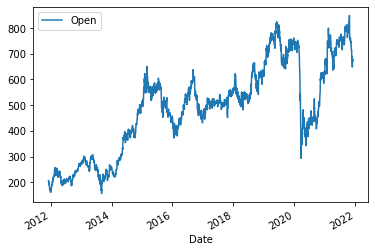

In [53]:
opn.plot()

In [54]:
import matplotlib.pyplot as plt

In [55]:
ds = opn.values

In [56]:
ds

array([[206.6000061 ],
       [207.        ],
       [196.27000427],
       ...,
       [679.09997559],
       [674.        ],
       [672.        ]])

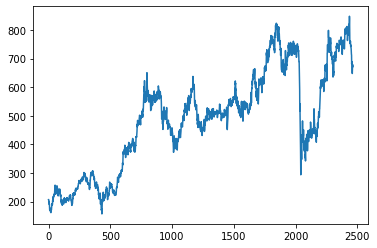

In [57]:
plt.plot(ds)

In [58]:
import numpy as np

In [59]:
from sklearn.preprocessing import MinMaxScaler

In [60]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))


In [61]:
len(ds_scaled), len(ds)

(2465, 2465)

In [62]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [63]:
train_size,test_size

(1725, 740)

In [64]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [65]:
len(ds_train),len(ds_test)

(1725, 740)

In [66]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [67]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [68]:
X_train.shape,y_train.shape

((1624, 100), (1624,))

In [69]:
X_test.shape, y_test.shape

((639, 100), (639,))

In [70]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [71]:
from keras.models import Sequential,load_model
from keras.layers import Dense, LSTM

In [72]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [73]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
26/26 [==============================] - 10s 205ms/step - loss: 0.0229 - val_loss: 0.0075
Epoch 2/100
26/26 [==============================] - 4s 162ms/step - loss: 0.0021 - val_loss: 0.0054
Epoch 3/100
26/26 [==============================] - 4s 173ms/step - loss: 0.0012 - val_loss: 0.0055
Epoch 4/100
26/26 [==============================] - 4s 168ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 5/100
26/26 [==============================] - 5s 199ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 6/100
26/26 [==============================] - 5s 179ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 7/100
26/26 [==============================] - 4s 173ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 8/100
26/26 [==============================] - 4s 167ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 9/100
26/26 [==============================] - 4s 161ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 10/100
26/26 [==============================] - 4s 163ms/step - loss: 0.0011 - val_l

26/26 [==============================] - 4s 171ms/step - loss: 2.7483e-04 - val_loss: 9.3329e-04
Epoch 79/100
26/26 [==============================] - 4s 173ms/step - loss: 2.7593e-04 - val_loss: 9.1398e-04
Epoch 80/100
26/26 [==============================] - 5s 176ms/step - loss: 2.6899e-04 - val_loss: 8.6209e-04
Epoch 81/100
26/26 [==============================] - 4s 170ms/step - loss: 2.6964e-04 - val_loss: 6.3172e-04
Epoch 82/100
26/26 [==============================] - 4s 170ms/step - loss: 2.4773e-04 - val_loss: 7.7524e-04
Epoch 83/100
26/26 [==============================] - 5s 191ms/step - loss: 2.5169e-04 - val_loss: 6.0374e-04
Epoch 84/100
26/26 [==============================] - 5s 177ms/step - loss: 2.5867e-04 - val_loss: 0.0010
Epoch 85/100
26/26 [==============================] - 4s 171ms/step - loss: 2.6525e-04 - val_loss: 7.9901e-04
Epoch 86/100
26/26 [==============================] - 4s 170ms/step - loss: 2.6581e-04 - val_loss: 9.7895e-04
Epoch 87/100
26/26 [=======

In [80]:
model.save("AXISBANK.h5")

In [81]:
 model=load_model('AXISBANK.h5')

In [82]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

AttributeError: 'NoneType' object has no attribute 'history'

In [83]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [84]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

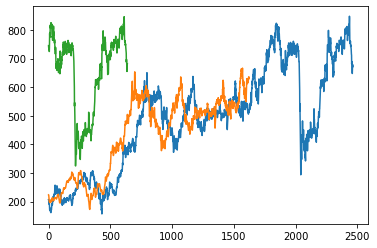

In [85]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [86]:
type(train_predict)

numpy.ndarray

In [87]:
test = np.vstack((train_predict,test_predict))

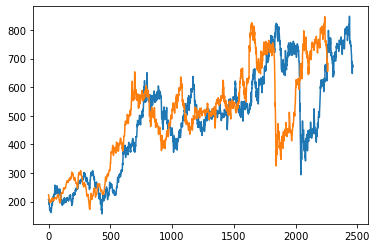

In [88]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [89]:
len(ds_test)

740

In [90]:
#Getting the last 100 days records
fut_inp = ds_test[640:]

In [91]:
fut_inp = fut_inp.reshape(1,-1)

In [92]:
tmp_inp = list(fut_inp)

In [93]:
fut_inp.shape

(1, 100)

In [94]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [95]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<100):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.7533177733421326], [0.7610630393028259], [0.7682313919067383], [0.7751015424728394], [0.7818323373794556], [0.7884288430213928], [0.7948563098907471], [0.8010829091072083], [0.8070865869522095], [0.8128529787063599], [0.8183751106262207], [0.8236521482467651], [0.8286895751953125], [0.8334991335868835], [0.8380958437919617], [0.8424985408782959], [0.8467277884483337], [0.8508049249649048], [0.85475093126297], [0.858585774898529], [0.8623272180557251], [0.8659910559654236], [0.869590163230896], [0.8731353878974915], [0.8766345977783203], [0.8800936937332153], [0.8835159540176392], [0.8869026899337769], [0.8902539610862732], [0.8935684561729431], [0.8968437910079956], [0.9000765681266785], [0.9032633900642395], [0.9064005613327026], [0.9094842076301575], [0.912510871887207], [0.9154770970344543], [0.9183796048164368], [0.9212164878845215], [0.9239851236343384], [0.9266843199729919], [0.9293127059936523], [0.9318695664405823], [0.9343547821044922], [0.9367688298225403], [0.93911230564

In [96]:
len(ds_scaled)
ds_scaled
# scaler.scale_
new=np.arange(1,101,1)
pred=np.arange(101,201,1)


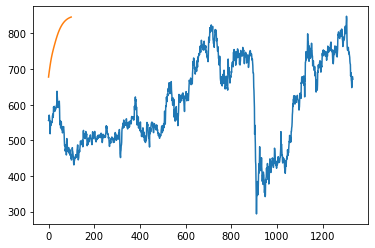

In [97]:
plt.plot(normalizer.inverse_transform(ds_scaled[1132:]))
plt.plot(normalizer.inverse_transform(lst_output))

In [98]:
ds_new = ds_scaled.tolist()

In [99]:
len(ds_new)

2465

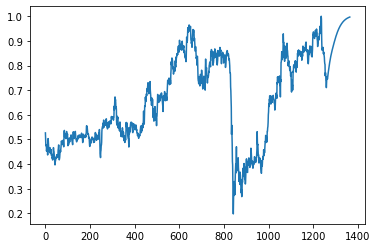

In [100]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [101]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

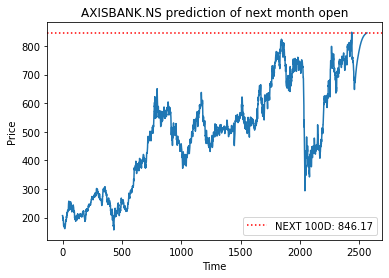

In [102]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 100D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

